In [110]:
import numpy.random as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from tqdm import tqdm_notebook as tqdm
sns.set()

parr = numpy.exp(numpy.arange(-24, -14)) #Mutation rate
narr = numpy.exp(numpy.arange(14, 25)) #Cell number
# garr = numpy.array([0.03125, 0.0625, 0.125, 0.25, 0.5]) #Growth rate increment

ndiv = 365
age = 80 #Lifespan
time = ndiv*age #Duration of the simulation
n_mut = numpy.zeros(time, dtype=int) #Number of mutations

threshold = 5 #Mutation threshold for cancer
n = narr[8] #Carrying capacity
p = parr[8] #Mutation rate
m = numpy.zeros((threshold+1)*time).reshape(threshold+1, time)
# k = numpy.linspace(n, 2*n, num=threshold+1)

# g_inc = garr[-1]
# g = 0.007*numpy.arange(1, threshold+2) #Growth rate progression
garr = np.normal(0.007, 0.05, time*(threshold+1))
# g = numpy.linspace(0.007, 0.09, num=threshold+1)
d = 0.007/5 #Constant death rate
# delta = 0.001*g[0]
m[0, 0] = n

p_mut = numpy.zeros(time)

for t in tqdm(range(1, time)):
    
    n_mut[t] = n_mut[t-1]
    m[:, t] = m[:, t-1]
    p_mut[t] = 1-(1-p)**m[n_mut[t], t]
    
    g = garr[(threshold+1)*(t-1):(threshold+1)*t]

    if p_mut[t] > np.random_sample(): #New mutant population
        n_mut[t] += 1
        m[n_mut[t], t] = 1.0
        p_mut[t] = 1-((1-p)**m[n_mut[t], t])
        m[n_mut[t]-1, t] -= 1.0

    elif n_mut[t] < threshold: #Growth of existing mutant or normal population, as the case may be
        m[:, t] += ((m[:, t]*g*(n-m[:, t].sum())/n) - m[:, t]*d)
        p_mut[t] = 1-(1-p)**m[n_mut[t] ,t]
    
#     g[n_mut[t]] -= delta

    if n_mut[t] == threshold:
        break

/home/iiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


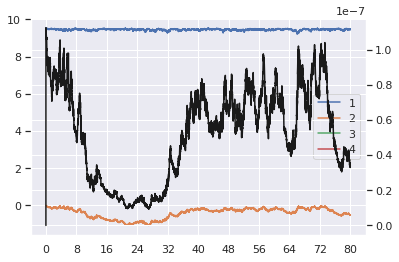

In [111]:
fig, ax = plt.subplots()
for i,l in zip(numpy.log10(m), [1, 2, 3, 4]):
    ax.plot(i, label=l)
plt.xticks(numpy.linspace(0, age, num=11)*ndiv, numpy.linspace(0, age, num=11, dtype=int))
# plt.xlabel('Time (days)')
plt.legend(loc='best')

mx = ax.twinx()
mx.plot(p_mut, 'k')

/home/iiser/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


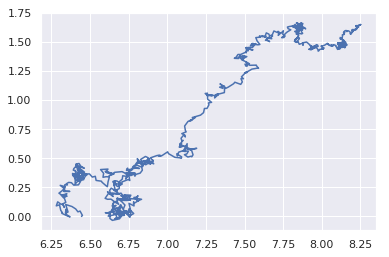

In [63]:
plt.plot(numpy.log10(m[0]), numpy.log10(m[1:].T))

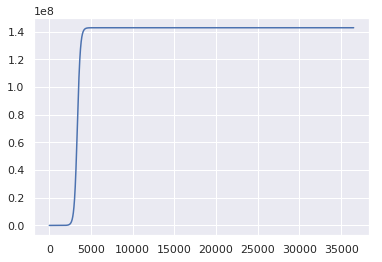

In [95]:
plt.plot(m.sum(axis=0))

## 20 October-
- Cancer onset around mid-life can be gotten with:
    - `g = 0.007*numpy.arange(1, threshold+2).cumsum()` and `d = g[0]/10`, or
    - `g = 0.007*numpy.arange(1, threshold+2)` and `d = g[0]/5`

## 22 October-
- Also getting rid of longitudinal recordings of cell type population sizes, in the hope that it frees computational power and lets the code run faster. At the expense of generating plots like the ones below, combining cell population trajectories and mutation accumulation.

# Mutational meltdown-not straightforward.
## Scaling delta with the "longer" logistic growth => we should probably use a physiological process to get estimates of delta over time, or simulate deleterious mutations in some way other than a growth rate decreasing in time.

## Weird dynamics between mutant populations
- For the usual range of g and slightly larger lifespans, the populations begin to cycle and seem to reach stable oscillations with little convergence.
    ### This is now better understood-for a given `k`, large values of `g` lead to fluctuations as the carrying capacity is approached and exceeded in a single step of logistic growth, with subsequent steps leading to further oscillations around the carrying capacity as the large `g` prevents convergence.

## Other observations
- Mutation occurrence and clonal expansion can progress on different time scales; for the following parameter set, five mutations do accumulate only for an unrealistic lifespan of **500 years**, but the individual only sees three rounds of clonal expansion starting with the first mutation:
    - `g = numpy.linspace(0.1, 2, threshold+1)`
    - `d = g[0]/5`
    - `n = narr[5]`
    - `p = parr[5]`
    -  A similar effect can be seen with a lifespan of **100 years** for `g = numpy.linspace(0.1, 3, threshold+1)`, where mutations continue to occur even if clonal expansion of the mutant is not complete.
    - This could be suggestive of the following things:
        - Mutation accumulation does not depend as stringently on clonal expansion as usually thought. So far, we've used the `p_mut` equation to talk about how much cell growth is required for a mutation event to become a certainty. Under this observation, it turns out that this cell growth could be well short of the population size at the point of competitive exclusion.
        - The `p_mut` equation is an inaccurate way of generating mutations; at face value, I don't see how or why this could be true, and more importantly, I cannot think of other ways of generating mutants.
        - This could be a trivial observation in the first place; after all, what matters to progression is the actual fixation of an advantageous mutation, and not only its selective advantage relative to non-mutant, or other mutant cells. In that sense, it is a fallacy of our model that we count cancer in terms of mutation occurrence and not clonal fixation. **However**, it is still significant that the timescales of the two are as different as reflected above. If indeed the accumulation of mutations is not predictive of cancer progression, genetic associations in this regard, as well as a large part of the "bad luck" argument no longer seem tenable; if cancer progression is a function of clonal expansion, which progresses on a different timeline compared to mutation accumlation, clearly mutations are not the drivers of progression. In fact, the primacy of clonal expansion and fixation in the population suggested by this observation only gives more time and space for context-dependent environmental and micro-environmental factors to act on cancer progression.
- There is a delicate balance between the progression of growth rates between mutations, and the differences between consecutive growth rates. As with the ideal sampling for `n` and `p`, this again concerns the use of `numpy.linspace()` across even two orders of magnitude. Since the step size is chosen based on the minimum and maximum values, the gap between the non-mutant and first mutant often tends to be that of an order of magnitude, while subsequent gaps are all of the same order. This disproportionality leads to the first mutation reaching fixation early in life, but subsequent fixation times are longer since the gaps in growth rates are not even.
    - These effects of the sampling coarseness also show that the non-mutant growth rate cannot be arbitrarily low; in order for competitive growth and mutant fixation to occur, the initial non-mutant growth rate must be a reasonable value. If not, growth in the non-mutant population, and indirectly in the mutant population, is much slower, as smaller growth rates produce smaller decrements in the non-mutant populations. This lower limit on the non-mutant growth rate also sets a similar lower limit on the growth rates of the mutants, as well as an upper limit, based on the logic explained in the earlier point regarding the sampling coarseness. This then puts cancer progression in a fix; the only way to ensure mutation accumulation is to increase the lifespan, as both decreasing the non-mutant growth rate and increasing the mutant growth rate are problematic, even though they increase the selective advantage to the mutant in a straight contest.